In [1]:
img_size = 94*8
num_classes = 0 # will automatically be found
path = "coviddataset/"

In [2]:
#required libraries
import os, math, scipy.ndimage
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,8) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
K.set_image_data_format('channels_first')

In [3]:
all_dataset = []
all_labels = []

def image_to_matrix(image_path): # R x C seklinde matrix dondurecek 
    try:
        img = Image.open(image_path).convert('L')
        if img.size != (img_size, img_size):
            resized_img = img.resize((img_size,img_size))
            resized_img.save(image_path, 'png')
            return np.asarray(resized_img)
        else:
            return np.asarray(img)
    except:
        pass
    
# verilen klasor icinde belirledigimiz oran icin kac tane resim oluyor bunu sayacak
# example output: (num_train, num_test)
def how_many_images_in_the_set(path, train):
    total_images = len(os.listdir(path)) * 8
    return math.ceil(total_images * train)

# verilen klasor icindeki tum dosyalari matrix arrayi olarak dondurur. N x R x C
def fetch_images(path, index, train=0.7):
    if os.path.isdir(path): # eger dongudeki dosya bir klasor ise ->
        files = []
        for file in os.listdir(path): # buldugumuz klasorun icindeki dosyalari listeleyelim
            if not "._" in file:
                img_array = np.array(image_to_matrix(path+"/"+file))
                all_dataset.append(img_array)
                all_labels.append(index)
                files.append([img_array, index])
                files.append([np.rot90(img_array, 1), index])
                files.append([np.rot90(img_array, 2), index])
                files.append([np.rot90(img_array, 3), index])
                files.append([np.fliplr(img_array), index])
                files.append([np.rot90(np.fliplr(img_array), 1), index])
                files.append([np.rot90(np.fliplr(img_array), 2), index])
                files.append([np.rot90(np.fliplr(img_array), 3), index])
                
        np.random.shuffle(files) #shuffle data in this folder
        num_train = how_many_images_in_the_set(path, train)
        # example output: train: 0-72, test: 72-80
        print ('files length: %d index: %d' %(len(files), index))
        return (files[:num_train], files[num_train:])
        

In [4]:
# will be N x [images, label]
train_dataset = []
test_dataset = []
label_index = 0

for folder in os.listdir(path): # verdigimiz path icindeki dosyalari listeliyoruz
    if not "." in folder:
        (train, test) = fetch_images(path+folder, label_index) # 
        print ("%s folder is being attached to the dataset" %(folder))
        print ("total files attached: train: %d  test: %d" %(len(train), len(test)))
        train_dataset += train
        test_dataset  += test
        label_index += 1

num_classes = label_index
print( "total number of classes: ", num_classes )
    
np.random.shuffle(train_dataset)
np.random.shuffle(test_dataset)

files length: 552 index: 0
covid folder is being attached to the dataset
total files attached: train: 387  test: 165
files length: 200 index: 1
normal folder is being attached to the dataset
total files attached: train: 140  test: 60
total number of classes:  2


In [5]:
X_train = []
y_train = []
X_test  = []
y_test  = []

for data in train_dataset:
    if data[0].shape == (img_size, img_size):
        X_train.append(data[0])
        y_train.append(data[1])
    
for data in test_dataset:
    if data[0].shape == (img_size, img_size):
        X_test.append(data[0])
        y_test.append(data[1])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test  = np.array(X_test)
y_test  = np.array(y_test)
all_dataset  = np.array(all_dataset)
all_labels  = np.array(all_labels)


print ("X_train: ", X_train.shape, "\ny_train: ", y_train.shape, "\nX_test : ", X_test.shape, "\ny_test : ", y_test.shape, "\nall_dataset : ", all_dataset.shape, "\nall_labels : ", all_labels.shape)

X_train:  (527, 752, 752) 
y_train:  (527,) 
X_test :  (225, 752, 752) 
y_test :  (225,) 
all_dataset :  (94, 752, 752) 
all_labels :  (94,)


In [6]:
# veriyi normalize ediyoruz
# since our data includes numbers between 0 and 255
# we will scale them so that they are between 0 and 1
X_train = X_train / 255.0
X_test  = X_test  / 255.0
all_dataset = all_dataset / 255.0

# etiketlerimizi one-hot vektor haline getiriyoruz
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)
All_labels = np_utils.to_categorical(all_labels, num_classes)

In [25]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(752, 752)),
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(.2, input_shape=(2,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(256, activation='elu'),
  tf.keras.layers.Dense(10, activation='sigmoid')
])

In [26]:
# build the model
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [27]:
r = model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=10)

Epoch 1/10
17/17 [==============================] - 4s 187ms/step - loss: 1.0532 - accuracy: 0.6729 - val_loss: 0.5807 - val_accuracy: 0.7333
Epoch 2/10
17/17 [==============================] - 3s 160ms/step - loss: 0.6493 - accuracy: 0.7062 - val_loss: 0.6341 - val_accuracy: 0.7333
Epoch 3/10
17/17 [==============================] - 3s 160ms/step - loss: 0.6120 - accuracy: 0.7329 - val_loss: 0.5806 - val_accuracy: 0.7333
Epoch 4/10
17/17 [==============================] - 3s 162ms/step - loss: 0.5750 - accuracy: 0.7438 - val_loss: 0.6569 - val_accuracy: 0.7333
Epoch 5/10
17/17 [==============================] - 3s 161ms/step - loss: 0.6399 - accuracy: 0.6719 - val_loss: 0.5936 - val_accuracy: 0.7333
Epoch 6/10
17/17 [==============================] - 3s 159ms/step - loss: 0.6250 - accuracy: 0.7048 - val_loss: 0.6067 - val_accuracy: 0.7333
Epoch 7/10
17/17 [==============================] - 3s 159ms/step - loss: 0.6298 - accuracy: 0.7249 - val_loss: 0.5864 - val_accuracy: 0.7333
Epoch 

In [10]:
r.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

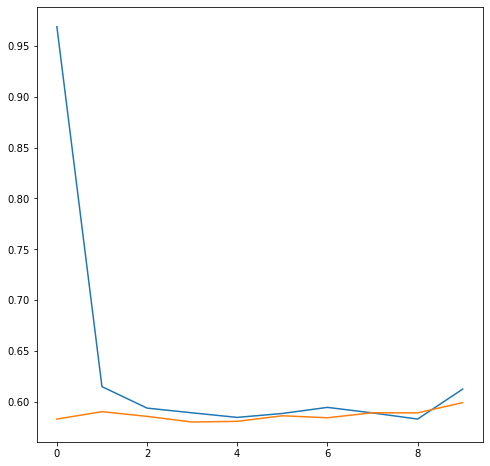

In [11]:
# görselleştirme işlemi 
import matplotlib.pyplot as plt
plt.figure()
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

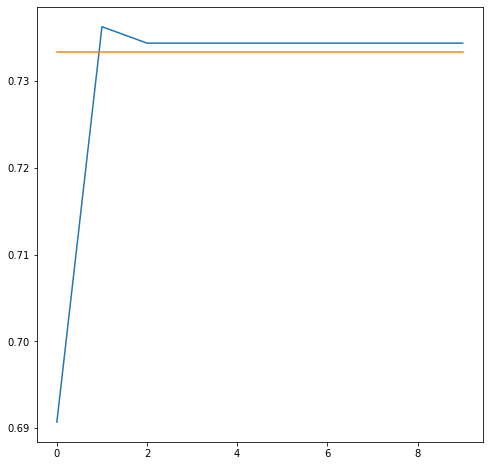

In [16]:
# görselleştirme işlemi
plt.figure()
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')

In [17]:
prediction = model.predict(X_test)

In [19]:
# bazı örnekleri göstermek için
import numpy as np
import matplotlib.pyplot as plt

def compare(index):
  p = np.argmax(prediction[index])
  r = y_test[index]
  plt.figure()
  plt.title('predicted: {}, real: {}'.format(p, r), size=30)
  plt.imshow(X_test[index], cmap='gray')

In [20]:
np.where(np.argmax(prediction, axis=1) != y_test)

(array([  1,   2,  11,  13,  14,  15,  17,  19,  26,  28,  29,  30,  31,
         35,  40,  44,  46,  48,  52,  59,  64,  67,  82,  84,  85,  86,
         90,  92,  94, 113, 118, 119, 125, 132, 134, 136, 140, 141, 153,
        155, 160, 164, 176, 178, 180, 181, 182, 188, 191, 195, 200, 202,
        203, 207, 210, 214, 217, 218, 221, 224], dtype=int64),)

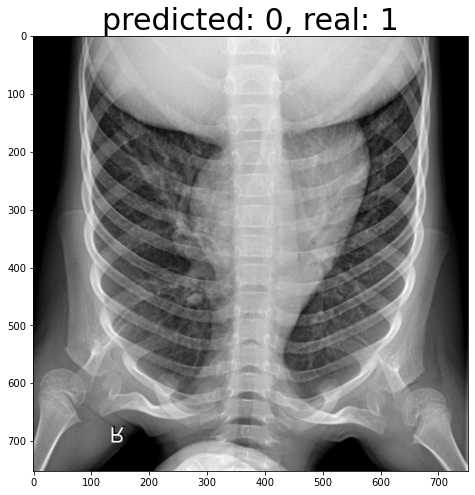

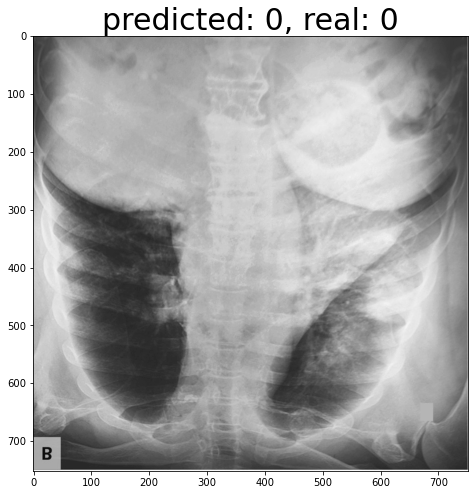

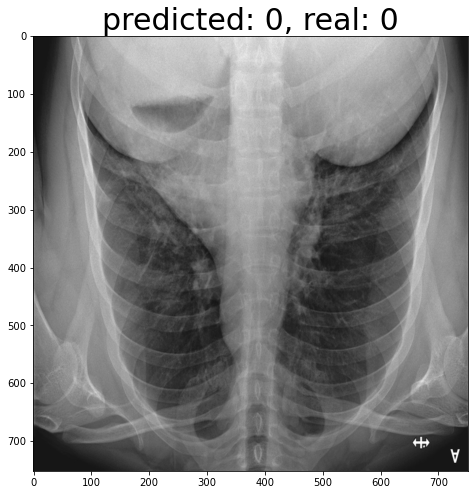

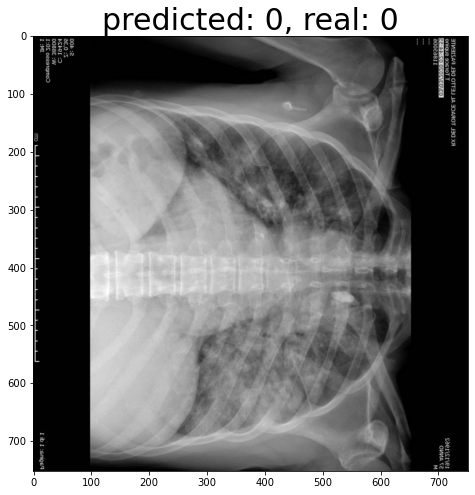

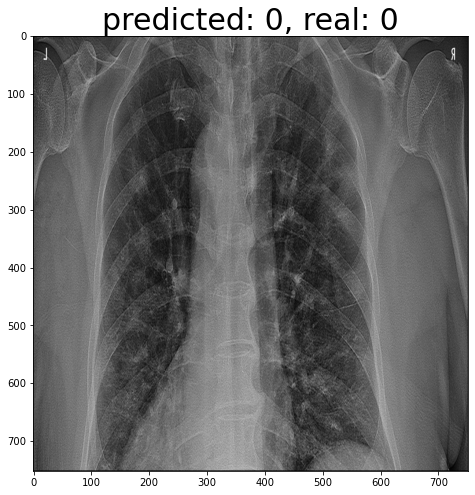

In [21]:
for i in [2, 3, 4, 209, 171]:
  compare(i)